# Task 4 Dimensionality Reduction (PCA)

In [5]:
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
plt.rcParams['figure.dpi'] = 120

# load design matrix from Task 3 
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'feature_engineer(task3)'))





from feature_engineer import run_full_pipeline

df = pd.read_csv('../student_success_survey.csv')
df = df[df["pillar"] != "Other"].copy()
design_df = run_full_pipeline(df)
TARGET = 'final_course_score'
y = design_df[TARGET]
X = design_df.drop(columns=[TARGET])
NUMERIC = X.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL = X.select_dtypes(exclude=[np.number]).columns.tolist()
pillar = df.loc[design_df.index, 'pillar']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
pillar_train = pillar.loc[X_train.index]
from sklearn.impute import SimpleImputer
num_pipe = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
pre = ColumnTransformer([('num', num_pipe, NUMERIC), ('cat', cat_pipe, CATEGORICAL)], remainder='drop')
X_train_np = pre.fit_transform(X_train)
X_test_np  = pre.transform(X_test)
print(f"\nPreprocessed design matrix — Train: {X_train_np.shape}, Test: {X_test_np.shape}")


Preprocessed design matrix — Train: (188, 26), Test: (48, 26)


/tmp/ipykernel_58247/661786447.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


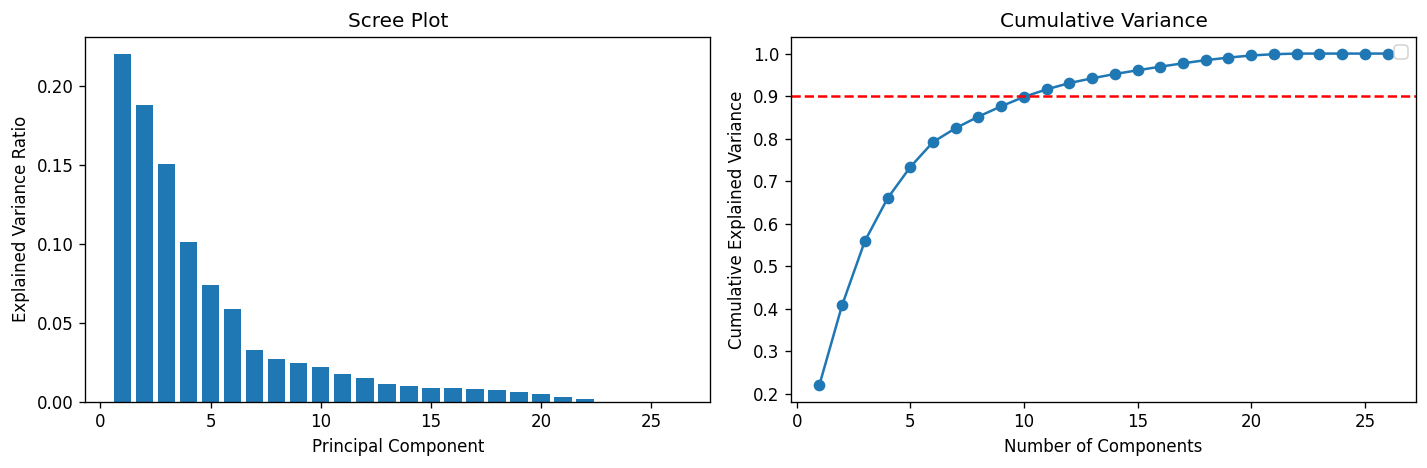

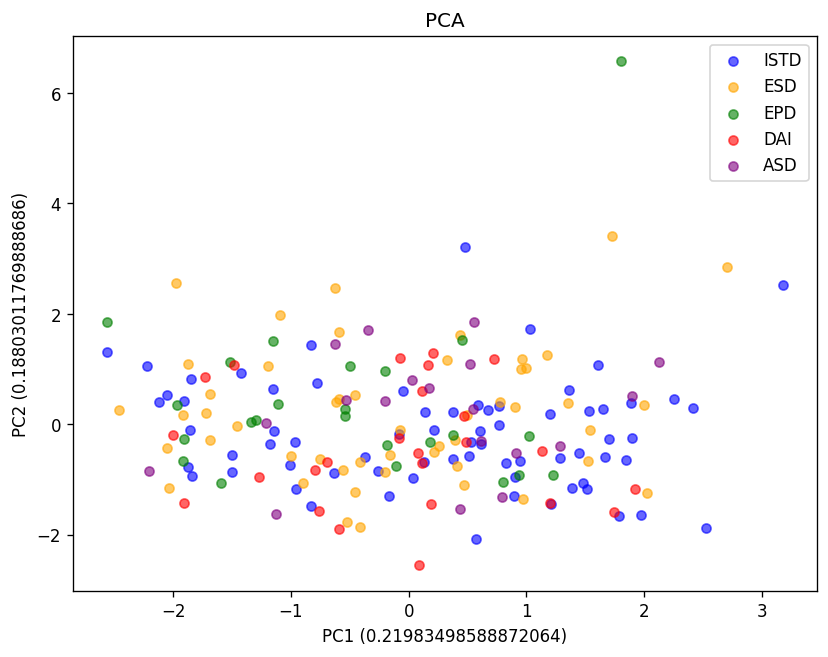

PC1 + PC2 explain 0.4078651035876075 of total variance


In [ ]:
# fit on train to prevent leak
pca_full = PCA(random_state=SEED)
pca_full.fit(X_train_np)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
cumulative = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumulative) + 1), cumulative, 'o-')
axes[1].axhline(y=0.9, color='r', linestyle='--')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()
plt.tight_layout()
plt.show()








pca_2d = PCA(n_components=2, random_state=SEED)
Z = pca_2d.fit_transform(X_train_np)
colors = {'ISTD':'blue', 'ESD':'orange', 'EPD':'green', 'DAI':'red', 'ASD':'purple'}
plt.figure(figsize=(8, 6))
for p, c in colors.items():
    mask = pillar_train.values == p
    plt.scatter(Z[mask, 0], Z[mask, 1], c=c, label=p, alpha=0.6, s=30)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]})')
plt.title('PCA')
plt.legend()
plt.show()

print(f"PC1 + PC2 explain {pca_2d.explained_variance_ratio_.sum()} of total variance")

### Do students cluster by pillar?
No as the pillars overlap a lot and randomly in the 2D projection. The survey features (grit, study habits, diagnostics) measure individual readiness traits that are pillar independent, so an ISTD student looks similar to someone from ESD.

### What PCA does not tell us
1. Non-linear structure: PCA is linear, complex non-linear relationships cannot be seen. Use t-SNE or UMAP for that.
2. Predictive relevance: The highest variance direction may capture noise for predicting final_course_score. 
3. The class separation: PCA does not optimise for separating groups 